#Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# 
from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
#
pd.set_option('display.max_columns', 500)  # force pandas to display all columns for better visual inspection
# plot plots inline
%matplotlib inline  

#Dataset IO

In [2]:
# Read training set into memory
# trn = pd.read_csv('./data/train.csv')
trn_10 = pd.read_csv('./data/train_10.csv')
trn_1 = pd.read_csv('./data/train_1.csv')

In [4]:
# Generate random sample and save into file
trn_10 = trn.sample(frac=0.1)  # random sample 10% from whole sample
trn_10.to_csv('./data/train_10.csv')  # save randome sub-samples to a csv file
trn_1 = trn.sample(frac=0.01)  # random sample 1% from whole sample
trn_1.to_csv('./data/train_1.csv')  # save randome sub-samples to a csv file

# ML

## Preprocessing 

In [3]:
# Extract matrix-form data from pandas df
X = trn_10.loc[:, 'minutes_past':'Kdp_5x5_90th'].values  # NOTE: used range slicing on column
y = trn_10['Expected'].values

In [17]:
# Split data as training and validation set
[X_trn, X_val, y_trn, y_val] = train_test_split(X, y, test_size = 0.3)

## Missing values

In [22]:
# Deal with missing values
imp = Imputer(strategy='mean')  # Get a imputor with column-mean filling config
X_trn = imp.fit_transform(X_trn)
X_val = imp.fit_transform(X_val)

In [23]:
print X_trn.shape, X_val.shape, y_trn.shape, y_val.shape

(963564L, 22L) (412956L, 22L) (963564L,) (412956L,)


## Training and prediction

In [24]:
clf = RandomForestRegressor(n_jobs=-1)  # NOTE: n_jobs=-1 will use all of your cores, set to a prefered number
clf.fit(X_trn, y_trn)
y_val_predict = clf.predict(X_val)

## Performance evaluation 

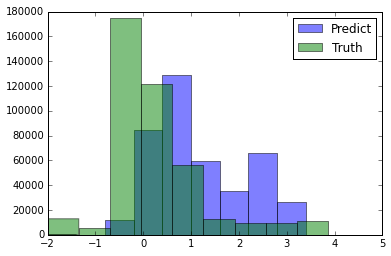

In [33]:
plt.hist(np.log10(y_val_predict), alpha = 0.5)
plt.hist(np.log10(y_val), alpha = 0.5)
plt.legend(['Predict','Truth'])

In [27]:
print ((y_val_predict-y_val)**2).mean()

265344.82535


# Test code below

In [29]:
# print trn[trn['Id']==8]
print trn[trn['Ref'].isnull()]['Id'].nunique()
print trn['Id'].nunique()


907906
1180945


In [46]:
trn[trn['Ref'].isnull()&(trn['Id']==4)].head(20)

,Id,minutes_past,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,RefComposite_5x5_90th,RhoHV,RhoHV_5x5_10th,RhoHV_5x5_50th,RhoHV_5x5_90th,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th,Expected
35,4,23,9,NaN,NaN,NaN,26,7.5,12,18.5,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.064002
40,4,47,9,NaN,NaN,NaN,20,11.0,NaN,12.5,21.5,NaN,NaN,NaN,1.008333,NaN,NaN,NaN,0.5625,NaN,NaN,NaN,5.62999,4.064002
41,4,52,9,NaN,NaN,NaN,11,NaN,NaN,6.5,15.0,NaN,NaN,NaN,1.005000,NaN,NaN,NaN,0.5625,NaN,NaN,NaN,NaN,4.064002


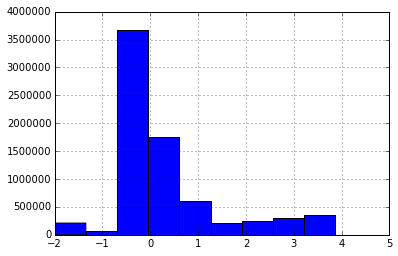

In [38]:
np.log10(trn[trn['Ref'].isnull()]['Expected']).hist()
# plt.show()

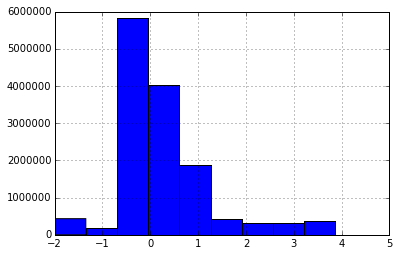

In [40]:
np.log10(trn['Expected']).hist()

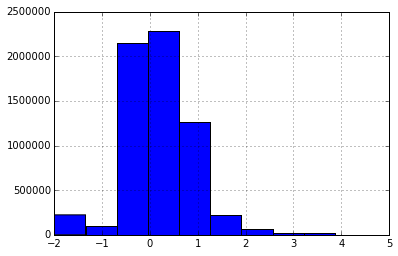

In [39]:
np.log10(trn[~trn['Ref'].isnull()]['Expected']).hist()

In [7]:
y_trn = y_trn.transpose()
y_val = y_val.transpose()

In [8]:
print y_trn.shape
print y_val.shape

(9635640L, 1L)
(4129561L, 1L)
